[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2023-03-02 to 2024-02-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       248 non-null    float64
 1   High       248 non-null    float64
 2   Low        248 non-null    float64
 3   Close      248 non-null    float64
 4   Adj Close  248 non-null    float64
 5   Volume     248 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


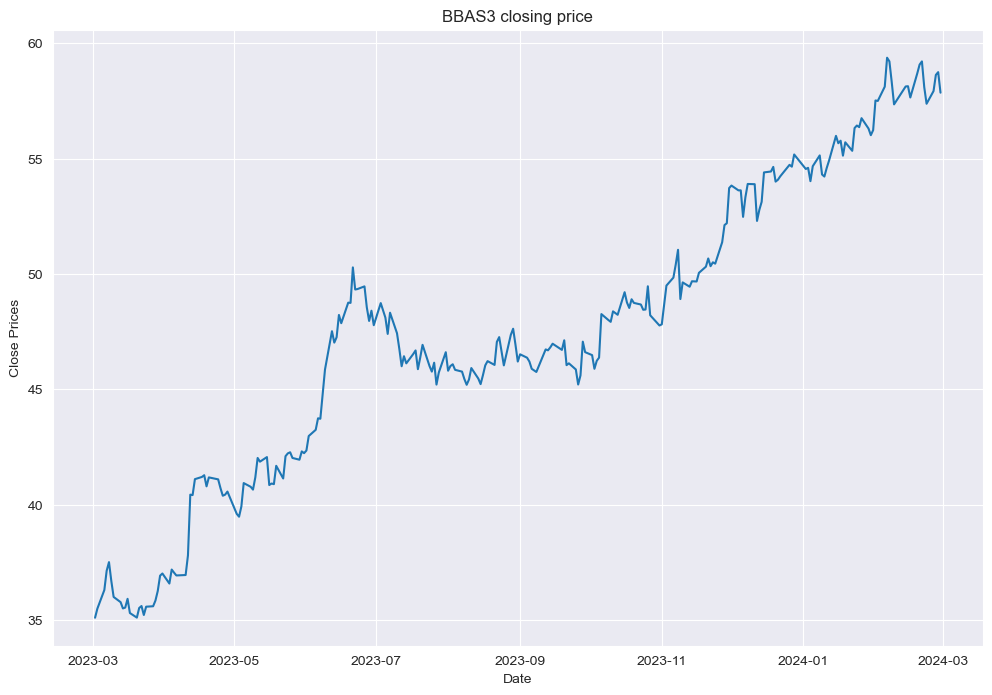

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=1056.060, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=521.952, Time=1.96 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=1219.922, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=571.599, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=512.350, Time=5.38 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=10.90 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=1017.803, Time=2.50 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=514.034, Time=5.76 sec
 ARIMA(1,0,1)(2,1,0)[30] intercept   : AIC=514.021, Time=5.46 sec
 ARIMA(0,0,1)(2,1,0)[30] intercept   : AIC=822.581, Time=3.51 sec
 ARIMA(2,0,1)(2,1,0)[30] intercept   : AIC=513.229, Time=10.84 sec
 ARIMA(1,0,0)(2,1,0)[30]             : AIC=i

,Adj Close
Date,
2023-03-02,35.103367
2023-03-03,35.497257
2023-03-06,36.303795
2023-03-07,37.138481
2023-03-08,37.513615
...,...
2024-02-23,57.380001
2024-02-26,57.930000
2024-02-27,58.630001


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Figure size 2000x500 with 0 Axes>

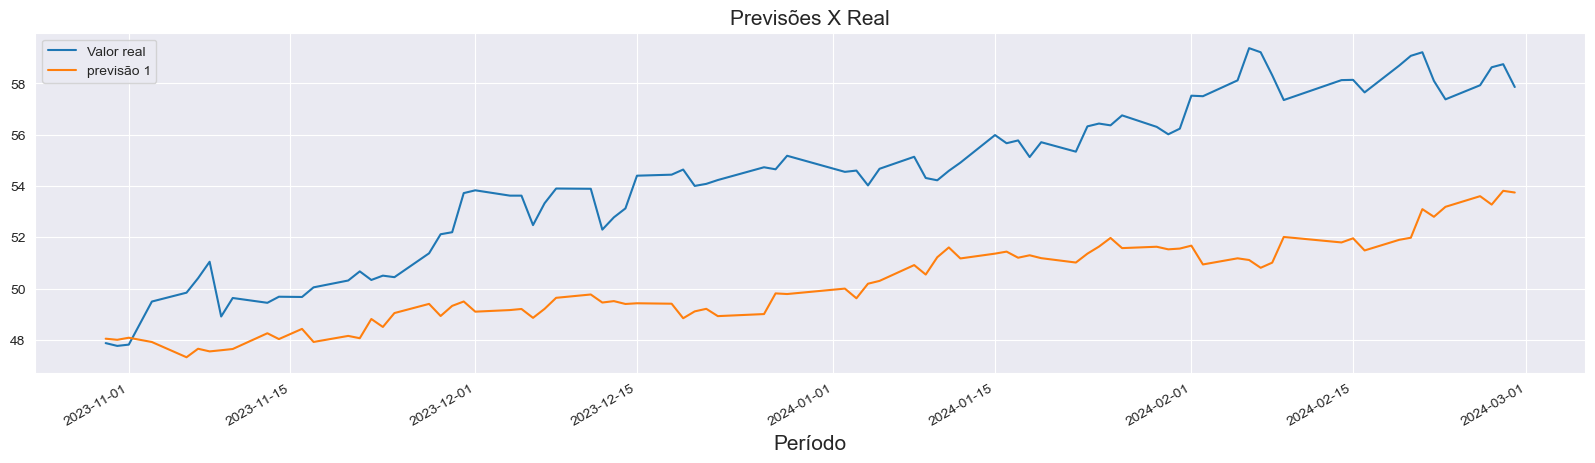

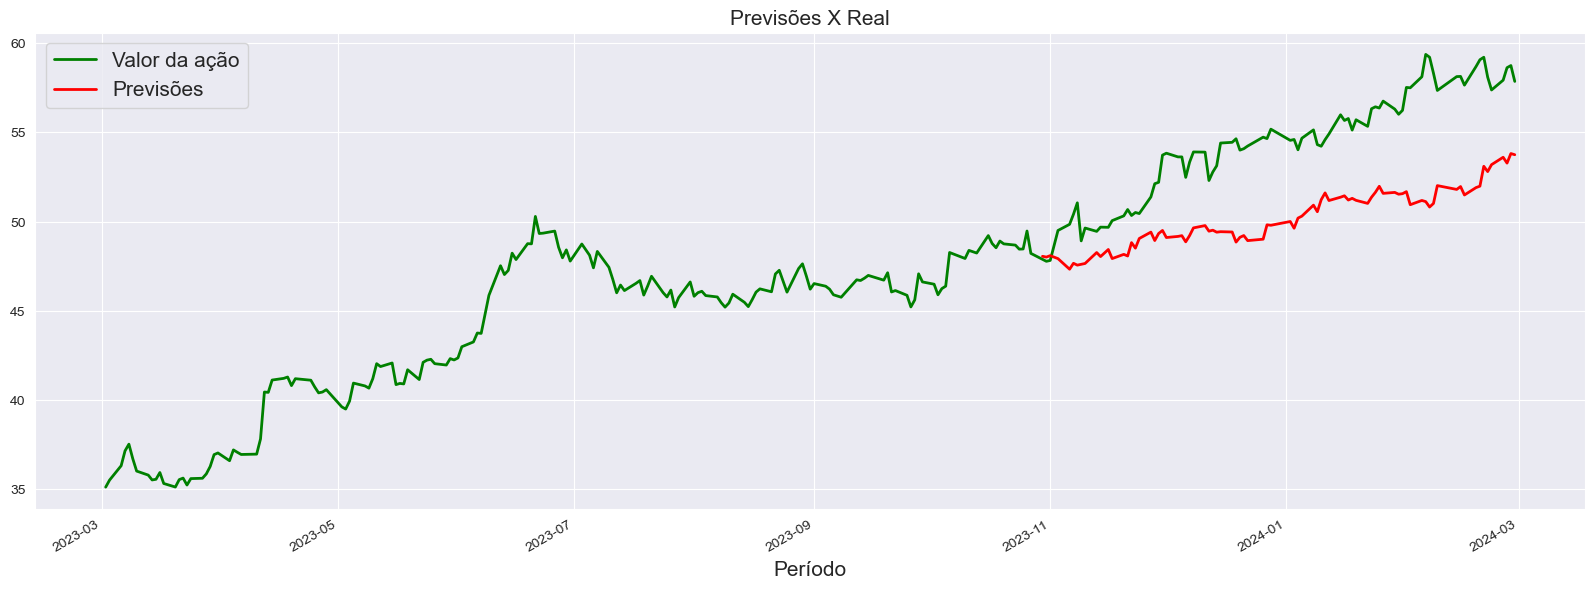


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 20.16072129560496
Median Absolute Deviation (MAD): 4.347171264890253
Mean Absolute Error (MAE): 4.134502906547855
R-squared (R²): -1.1086830369883165
[CV] fold=0 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=1 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=2 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=3 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=4 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=5 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=6 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=7 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=8 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=9 ..........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=10 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=11 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=12 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=13 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=14 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=15 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=16 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=17 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=18 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=19 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=20 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=21 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=22 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=23 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=24 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=25 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=26 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=27 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=28 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=29 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=30 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=31 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=32 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=33 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=34 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=35 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=36 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=37 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=38 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=39 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=40 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=41 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=42 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=43 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=44 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=45 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=46 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=47 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=48 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=49 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=50 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=51 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=52 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=53 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=54 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=55 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=56 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=57 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=58 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=59 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=60 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=61 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=62 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=63 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=64 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=65 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=66 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=67 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=68 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=69 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=70 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=71 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=72 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=73 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=74 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=75 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=76 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=77 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=78 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=79 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=80 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=81 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=82 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=83 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=84 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=85 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=86 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=87 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=88 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=89 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=90 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=91 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=92 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=93 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=94 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=95 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=96 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=97 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=98 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=99 .........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=100 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=101 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=102 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=103 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=104 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=105 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=106 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=107 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=108 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=109 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=110 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=111 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=112 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=113 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=114 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=115 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=116 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=117 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=118 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=119 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=120 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=121 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=122 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=123 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=124 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=125 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=126 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=127 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=128 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=129 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=130 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=131 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=132 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=133 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=134 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=135 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=136 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=137 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=138 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=139 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=140 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=141 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=142 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=143 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=144 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=145 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=146 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=147 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=148 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=149 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=150 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=151 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=152 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=153 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=154 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=155 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=156 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=157 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=158 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=159 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=160 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=161 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=162 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=163 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=164 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=165 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=166 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[CV] fold=167 ........................................................


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


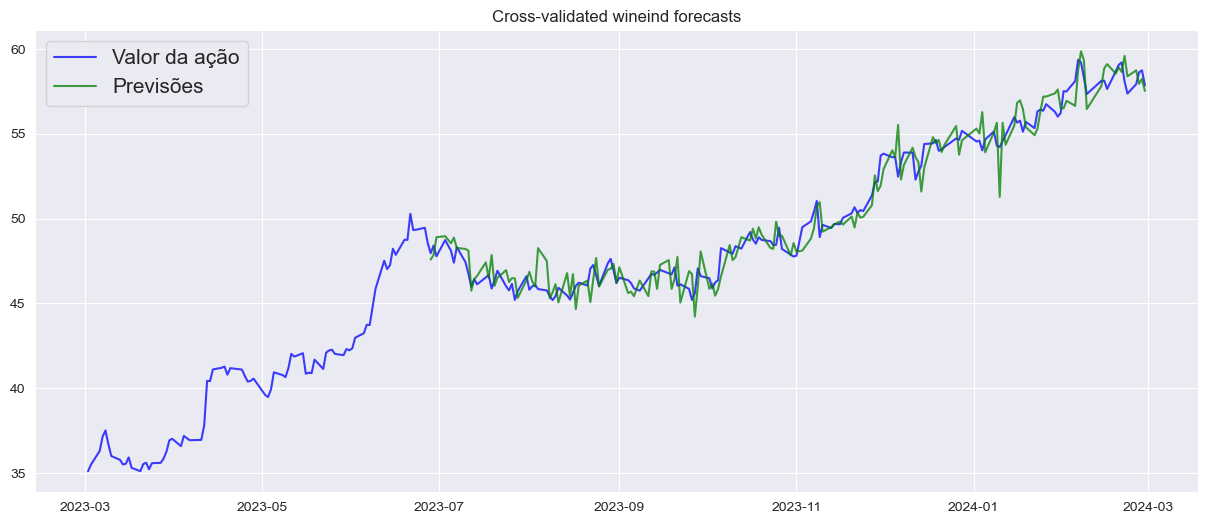


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 0.8606605005753255
Median Absolute Deviation (MAD): 0.5921028403647526
Mean Absolute Error (MAE): 0.7401710749810412
R-squared (R²): 0.9551814952306937


C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chico\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


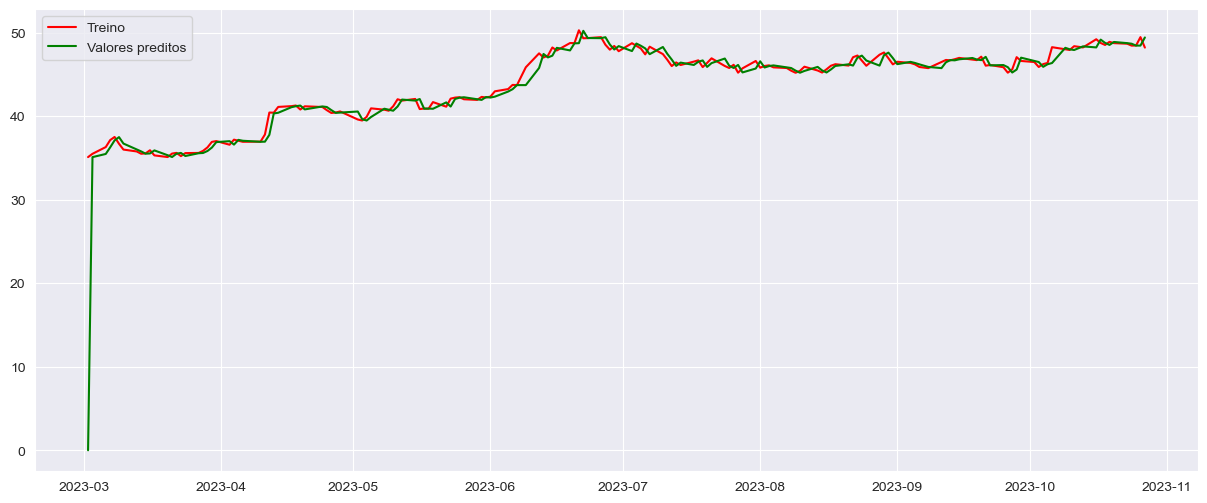

In [5]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importação de funções e constantes específicas
from functions.stock import download_stock_data
from const.interval import Interval

# Download dos dados históricos das ações
stock_data = download_stock_data("BBAS3.SA", Interval.DAY.value, 365)

# Exibição das informações dos dados
stock_data.info()

# Plotagem do preço de fechamento das ações
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('BBAS3 closing price')
plt.show()

# Seleção e limpeza dos dados relevantes
data = stock_data[["Adj Close"]].copy()
data.dropna(inplace=True)

# Ajuste automático do modelo ARIMA usando auto_arima
stepwise=auto_arima(data,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=3,
                    max_q=3,
                    max_d=3,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=30,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

# Exibição do AIC e BIC do modelo ajustado
print(stepwise.aic())
print(stepwise.bic())

# Visualização dos dados
display(data)

# Divisão dos dados em conjuntos de treinamento e teste
#metade_linhas = len(data) // 2
#treino=data['2023-02-24 10:00:00-03:00':"2024-02-12 10:00:00-03:00"]
#teste=data["2024-02-12 11:00:00-03:00":]

# Divisão dos dados em conjuntos de treinamento e teste
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
treino, teste = data[0:train_size], data[train_size:len(data)]

# Ajuste do modelo ARIMA aos dados de treinamento
stepwise.fit(treino)

# Geração de previsões com base no modelo ajustado
previsao=stepwise.predict(n_periods=len(teste))

# Transformação das previsões em um DataFrame
previsao_final=pd.DataFrame(previsao.values,index=teste.index, columns=["Adj Close"])

# Plotagem das previsões vs. teste
plt.figure(figsize=(20,5))
pd.concat([teste,previsao_final],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1'])

# Plotagem das previsões vs. dados reais
pd.concat([data,previsao_final],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show()

# Exibição do resumo do modelo ajustado
stepwise.summary()

# Avaliação de desempenho das previsões
from functions.validation import performance_evaluation
test_performance = performance_evaluation(teste, previsao_final)

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')

# Execução da validação cruzada
from pmdarima import model_selection

y = data
est = pm.ARIMA(order=(1, 0, 0),
               seasonal_order=(2, 1, 0, 40),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=80, step=1, h=1)
predictions = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

# Plotagem das previsões sobre a série original
x_axis = np.arange(y.shape[0])
n_test = predictions.shape[0]

plt.plot(y.index, y, alpha=0.75, c='b')
plt.plot(y.index[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.title("Cross-validated wineind forecasts")
plt.show()

# Avaliação de desempenho das previsões da validação cruzada
y_true = y[-n_test:]  
test_performance = performance_evaluation(y_true, predictions)

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')

# Ajuste do modelo SARIMAX aos dados de treinamento
modelo = SARIMAX(treino, order=(1, 0, 1), seasonal_order=(0,0,0,0)).fit(disp=0)

# Previsão usando o modelo ajustado
predito = modelo.predict(typ='levels')

# Plotagem dos valores reais vs. valores previstos
plt.plot(treino, color='red')
plt.plot(predito,color='green')
plt.legend(['Treino','Valores preditos'])
